<a href="https://colab.research.google.com/github/dinhsang1999/Hyperparameter-Tuning-with-Keras-Tuner/blob/main/Hyperparameter_Tuning_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 13.2 MB/s 


In [2]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [3]:
tf.__version__

'2.8.0'

In [4]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data() 

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

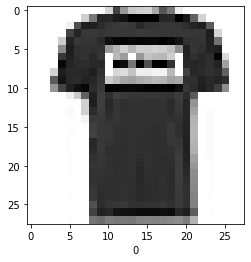

In [7]:
plt.imshow(x_train[1],cmap='binary')
plt.xlabel(y_train[1])
plt.show()

In [8]:
def create_model(hp):

  number_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers',values=[1,2,3])
    num_units = hp.Choice('num_units',values=[8,16,32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1,max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x:x/255,))

  for _ in range(0,number_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units,activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )
  return model


In [9]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [10]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
    super(CustomTuner,self).run_trial(trial,*args,**kwargs)


In [17]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashion_mnist',
    overwrite = True
)

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [19]:
tuner.search(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=5, verbose=True
)


Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1                 |3                 |num_hidden_layers
16                |32                |num_units
0.22815           |0.1949            |dropout_rate
0.0037339         |0.0095824         |learning_rate

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9143 - accuracy: 0.6587 - val_loss: 0.5868 - val_accuracy: 0.8059
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7441 - accuracy: 0.7240 - val_loss: 0.5571 - val_accuracy: 0.8129
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7198 - accuracy: 0.7328 - val_loss: 0.5916 - val_accuracy: 0.7957
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7094 - accuracy: 0.7384 - val_loss: 0.5403 - val_accuracy: 0.8179
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6882 - accuracy: 0.7502 - val_loss: 0.5330 - val_accuracy: 0.81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `Tuner.run_trial()` returned None. It should return one of float, dict, keras.callbacks.History, or a list of one of these types. The use case of calling `Tuner.oracle.update_trial()` in `Tuner.run_trial()` is deprecated, and will be removed in the future.
  after removing the cwd from sys.path.


ValueError: ignored

In [21]:
model = tuner.get_best_models(num_models=1)[0]

TypeError: ignored

In [20]:
_ = model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs=20,batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')]
)

NameError: ignored